# Investigation of Polish frogs dataset
---


The chosen dataset was found at the following link: https://archive.ics.uci.edu/ml/datasets/Amphibians

The Amphibians dataset was generated by the authors cited below to build and test a multiclass classifier that would predict the presence of 7 different species of amphibians, at sites along the proposed route of two new roads in Poland.  Detecting, identifying and counting amphibians is a specialised task that can only be completed in a limited time period, when they return to the water in spring.  The authors therefore used remote data from geographical information systems (GIS) and satellites to build the dataset, to create a less resource-intensive way of establishing their presence or absence.

For this study we consider the position of an ecologist who is concerned about the impact of the proposed new roads.  With access to the dataset but not the model, they are suspicious of the results and wish to replicate them themselves, to be convinced the results are accurate. They are also interested in feature importance, to discover the best ways of improving amphibian sites more generally.

For the authors' paper using this data, see: Marcin Blachnik, Marek Sołtysiak, Dominika Dąbrowska, *Predicting presence of amphibian species using features obtained from GIS and satellite images.* ISPRS International Journal of Geo-Information 8 (3) pp. 123. MDPI. 2019.  https://www.mdpi.com/2220-9964/8/3/123/htm.

## Software and data file setup

In [1]:
!pip install shap

In [2]:
!pip install lime

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import shap
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  ## for Lime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.inspection import PartialDependenceDisplay  
from sklearn import metrics
from sklearn.metrics import roc_curve, RocCurveDisplay, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from google.colab import drive

In [4]:
## connect to google drive
drive.mount('/content/drive')

csv_file = "./drive/MyDrive/Colab Notebooks/PolishFrogsdataset.csv"
## or fetch the file each time with !wget <url> maybe?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
## set a random seed
random.seed(42)

## Data exploration & cleansing

As a first step, the dataset will be explored.  We will check for missing values, regularise feature names, identify and separate labels, drop redundant fields, check data types, and inspect the range of values in each feature. Problems mapping feature values to feature descriptions will be discussed, and a working solution arrived at.  Class distribution will be examined, and initial analysis goals decided upon.

In [6]:
## row 0 is index of types 
col_types = pd.read_csv(csv_file, nrows = 0).columns

## read the data; headers on the second row
df = pd.read_csv(csv_file, header = 1, sep=';')

## inspect the data
df.head()

,ID,Motorway,SR,NR,TR,VR,SUR1,SUR2,SUR3,UR,...,BR,MR,CR,Green frogs,Brown frogs,Common toad,Fire-bellied toad,Tree frog,Common newt,Great crested newt
0,1,A1,600,1,1,4,6,2,10,0,...,0,0,1,0,0,0,0,0,0,0
1,2,A1,700,1,5,1,10,6,10,3,...,1,0,1,0,1,1,0,0,1,0
2,3,A1,200,1,5,1,10,6,10,3,...,1,0,1,0,1,1,0,0,1,0
3,4,A1,300,1,5,0,6,10,2,3,...,0,0,1,0,0,1,0,0,0,0
4,5,A1,600,2,1,4,10,2,6,0,...,5,0,1,0,1,1,1,0,1,1


In [7]:
## inspect the structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  189 non-null    int64 
 1   Motorway            189 non-null    object
 2   SR                  189 non-null    int64 
 3   NR                  189 non-null    int64 
 4   TR                  189 non-null    int64 
 5   VR                  189 non-null    int64 
 6   SUR1                189 non-null    int64 
 7   SUR2                189 non-null    int64 
 8   SUR3                189 non-null    int64 
 9   UR                  189 non-null    int64 
 10  FR                  189 non-null    int64 
 11  OR                  189 non-null    int64 
 12  RR                  189 non-null    int64 
 13  BR                  189 non-null    int64 
 14  MR                  189 non-null    int64 
 15  CR                  189 non-null    int64 
 16  Green frogs         189 no

There appear to be no missing values.  Looking at the raw data we do not see any codes such as '999' that might have been used to indicate a missing value, so this seems a reasonable assumption.  We can also see that some of the feature names contain spaces or hyphens, which will need to be removed.

In [8]:
## remove spaces from feature names...
df.columns = df.columns.str.replace(' ', '_')

## ''' and the hyphen
df.columns = df.columns.str.replace('-', '_')

## then compare data types with the datafile
print(col_types)

Index(['Integer;Categorical;Numerical;Numerical;Categorical;Categorical;Categorical;Categorical;Categorical;Categorical;Categorical;Numerical;Ordinal;Ordinal;Categorical;Categorical;Label 1;Label 2;Label 3;Label 4;Label 5;Label 6;Label 7'], dtype='object')


In [9]:
## convert category and ordinal fields from integer, based on data from csv file    
conv = ["TR", "VR", "SUR1", "SUR2", "SUR3", "UR", "FR", "RR", "BR", "MR", "CR"]

df[conv] = df[conv].astype('category') 

Before investigating the determining features of the dataset, we consider the classes the model will predict.  Blachnik *et al* investigated a multiclass classification model, with the following labels:

*17) Label 1 -> the presence of Green frogs*

*18) Label 2 -> the presence of Brown frogs*

*19) Label 3 -> the presence of Common toad*

*20) Label 4 -> the presence of Fire-bellied toad*

*21) Label 5 -> the presence of Tree frog*

*22) Label 6 -> the presence of Common newt*

*23) Label 7 -> the presence of Great crested newt*

[Note: Feature descriptions in *italics* are quoted from https://archive.ics.uci.edu/ml/datasets/Amphibians.  Numbers indicate the order of features in the CSV file (1-ordering)]

It will be useful to investigate how balanced the datset is, in respect of each class listed above.

In [10]:
## check how many labels of each type we have
print(df.Green_frogs.value_counts())
print(df.Brown_frogs.value_counts())
print(df.Common_toad.value_counts())
print(df.Fire_bellied_toad.value_counts())
print(df.Tree_frog.value_counts())
print(df.Common_newt.value_counts())
print(df.Great_crested_newt.value_counts())

1    108
0     81
Name: Green_frogs, dtype: int64
1    148
0     41
Name: Brown_frogs, dtype: int64
1    124
0     65
Name: Common_toad, dtype: int64
0    131
1     58
Name: Fire_bellied_toad, dtype: int64
0    118
1     71
Name: Tree_frog, dtype: int64
0    131
1     58
Name: Common_newt, dtype: int64
0    168
1     21
Name: Great_crested_newt, dtype: int64


It seems a fair assumption that a value of '1' in a label feature indicates that amphibian was present, and a value of '0' means they were absent, although this is not explicitly stated.

From the above we can see that the dataset is unbalanced for all the amphibians,  towards class '0' (absent) for four species and towards class '1' (present) for Green and Brown frogs, and the Common toad.  Of these, it is least unbalanced for Green frogs.  To avoid a complicated analysis, we will run and explain a model for Green frogs only - a binary classification problem.


In [11]:
## define the class names we have assumed
class_labels = ["Absent", "Present"]

# define row numbers for the data instances
instances = range(0, 189)

Next we look at each feature and consider if it will be relevant to the investigation, and if it is represented in the most effective way.  Subsequently, we will plot the frequency of values for all categorical features, as a visual guide to the data.

Feature descriptions:

*1) ID -> vector ID (not used in the calculations)*

*2) MV -> motorway (not used in the calculations)*

Since it is stated that these features were not used in the analysis, they can be dropped from the dataframe.

In [12]:
## drop fields that won't be used
df = df.drop(["ID", "Motorway"], axis = 1)

Feature descriptions:

*3) SR -> Surface of water reservoir numeric [m<sup>2</sup>]*

The surface area of the reservoir is a numeric feature.  We can see that the values vary over several orders of magnitude below.

In [13]:
## SR is a number
print("Minimum surface area, SR = ", min(df.SR), "square metres")
print("Maximum surface area, SR = ", max(df.SR), "square metres")

Minimum surface area, SR =  30 square metres
Maximum surface area, SR =  500000 square metres


Feature description:

*4) NR -> Number of water reservoirs in habitat - Comment: The larger the number of reservoirs, the more likely it is that some of them will be suitable for amphibian breeding.*

We examine the range of numeric feature, NR, Number of water reservoirs.

In [14]:
## NR is a number, not categorical 
print("Minimum no. of reservoirs, NR = ", min(df.NR))
print("Maximum no. of reservoirs, NR = ", max(df.NR))

Minimum no. of reservoirs, NR =  1
Maximum no. of reservoirs, NR =  12


Feature description:

*5) TR -> Type of water reservoirs:*

*a. reservoirs with natural features that are natural or anthropogenic water reservoirs (e.g., subsidence post-exploited water reservoirs), not subjected to naturalization*  
*b. recently formed reservoirs, not subjected to naturalization*  
*c. settling ponds*  
*d. water reservoirs located near houses*  
*e. technological water reservoirs*  
*f. water reservoirs in allotment gardens*  
*g. trenches*  
*h. wet meadows, flood plains, marshes*  
*i. river valleys*  
*j. streams and very small watercourses*

In [15]:
## examine feature TR - 10 values listed, 8 appear in data
TR_list = df['TR'].unique()
print("Values found in feature TR:", *TR_list)

Values found in feature TR: 1 5 12 14 15 11 2 7


At this point in data exploration it became apparent that there was an inconsistency between the descriptions of the features (a,b,c, etc) and the feature values, which are numeric.  Since contact details of two of the authors were available in the dataset description, an email was sent to request clarification, but unfortunately no answer was received.  It was decided to proceed with the analysis as an exercise, accepting this lack of clarity, and avoiding assumptions as far as was possible.

Feature description:

*6) VR - Presence of vegetation within the reservoirs:*

*a. no vegetation*  
*b. narrow patches at the edges*  
*c. areas heavily overgrown*  
*d. lush vegetation within the reservoir with some part devoid of vegetation*  
*e. reservoirs completely overgrown with a disappearing water table*  

*Comment: The vegetation in the reservoir favors amphibians, facilitates breeding, and allows the larvae to feed and give shelter. However, excess vegetation can lead to the overgrowth of the pond and water shortages.*

In [16]:
## examine feature VR - 5 and 5
VR_list = df['VR'].unique()
print("Values found in feature VR:", *VR_list)

Values found in feature VR: 4 1 0 2 3


Feature description:

*7) SUR1 - Surroundings -> the dominant types of land cover surrounding the water reservoir*

*8) SUR2 - Surroundings -> the second most dominant types of land cover surrounding the water reservoir*

*9) SUR3 - Surroundings -> the third most dominant types of land cover surrounding the water reservoir*

*Comment: The **surroundings** feature was designated in three stages. First, the dominant surroundings were selected. Then, two secondary types were chosen.*

*a. forest areas (with meadows) and densely wooded areas*  
*b. areas of wasteland and meadows*  
*c. allotment gardens*  
*d. parks and green areas*  
*e. dense building development, industrial areas*  
*f. dispersed habitation, orchards, gardens*  
*g. river valleys*  
*h. roads, streets*  
*i. agricultural land*

*The most valuable surroundings of water reservoirs for amphibians are areas with the least anthropopressure and proper moisture.*

In [17]:
## examine feature SUR1 - 9 values listed, 8 appear
SUR1_list = df['SUR1'].unique()
print("Values found in feature SUR1:", *SUR1_list)

## examine feature SUR2 - 9 values listed, 7 appear
SUR2_list = df['SUR2'].unique()
print("Values found in feature SUR2:", *SUR2_list)

## examine feature SUR3 - 9 values listed, 8 appear
SUR3_list = df['SUR3'].unique()
print("Values found in feature SUR3:", *SUR3_list)

Values found in feature SUR1: 6 10 2 1 7 14 9 4
Values found in feature SUR2: 2 6 10 1 7 9 11
Values found in feature SUR3: 10 2 6 9 1 7 11 5


Feature description: 

*10) UR - Use of water reservoirs:*

*a. unused by man (very attractive for amphibians)*  
*b. recreational and scenic (care work is performed)*  
*c. used economically (often fish farming)*  
*d. technological*


In [18]:
## examine feature UR - 4 listed, 3 appear
UR_list = df['UR'].unique()
print("Values found in feature UR:", *UR_list)

Values found in feature UR: 0 3 1


Feature description: 

*11) FR - The presence of fishing:*  

*a. lack of or occasional fishing*  
*b. intense fishing*  
*c. breeding reservoirs*

*Comment: The presence of a large amount of fishing, in particular predatory and intense fishing, is not conducive to the presence of amphibians.*

In [19]:
## examine feature FR - 3 listed, 5 appear!
FR_list = df['FR'].unique()
print("Values found in feature FR:", *FR_list)

Values found in feature FR: 0 1 4 2 3


Feature description: 

*12) OR - Percentage access from the edges of the reservoir to undeveloped areas (the proposed percentage ranges are a numerical reflection of the phrases: lack of access, low access, medium access, large access to free space):*

*a. 0 - 25% -> lack of access or poor access*  
*b. 25 - 50% -> low access*  
*c. 50 - 75% -> medium access,*  
*d. 75 - 100% -> large access to terrestrial habitats of the shoreline is in contact with the terrestrial habitat of amphibians.*


In [20]:
## examine feature OR - 4 listed, 6 appear!   
OR_list = df['OR'].unique()
print("Values found in feature OR:", *OR_list)

Values found in feature OR: 50 75 25 99 100 80


Feature OR, Access to undeveloped areas, is described as numerical but from the description above it appears to be categorical.  However the feature values appearing in the data do not cleanly represent the categories given.  For this study the numerical values of feature OR will be mapped on to new categories [0,1,2,3] that correspond exactly with categories a,b,c,d given above.  The mapping will simply bin the values into the described categories, so new category '0' will contain instances where OR is in the range 0 - 25%, corresponding to 'lack of access', and so on.

In [21]:
## create clean categories for feature OR        
OR_clean = [0]*len(df)          

## map values to categories
for i in instances:
  if df.OR[i] <= 25:
    OR_clean[i] = 0
  elif 25 < df.OR[i] <= 50:
    OR_clean[i] = 1
  elif 50 < df.OR[i] <= 75:
    OR_clean[i] = 2
  else:
    OR_clean[i] = 3

Feature OR_clean is now a genuine categorical variable which can replace the numerical feature OR in the dataframe.

In [22]:
df["OR_clean"] = OR_clean
## examine feature OR - cleaned
OR_clean_list = df['OR_clean'].unique()
print("Values found in feature OR_clean:", *OR_clean_list)

## tidying up
df["OR_clean"] = df.OR_clean.astype("category")
df = df.drop(["OR"], axis = 1)

Values found in feature OR_clean: 1 2 0 3


These values of new feature OR_clean provide the four categories as the data is described: "lack of access, low access, medium access, large access to free space".

Feature description:

*13) RR Minimum distance from the water reservoir to roads:*

*a. <50 m*  
*b. 50 - 100 m*  
*c. 100 - 200 m*  
*d. 200 - 500 m*  
*e. 500 - 1000 m*  
*f. >1000 m*

*Comment: The greater the distance between the reservoir and the road, the more safety for amphibians.*

In [23]:
## examine feature RR - 6 listed, 6 appear
RR_list = df['RR'].unique()
print("Values found in feature RR:", *RR_list)

Values found in feature RR: 0 1 2 9 5 10


There are 6 values that occur in feature RR, Distance to roads, and 6 categories in the dataset description, ranging from '< 50m' to '> 1000m'.  We might assume there is a 1:1 relationship between them but this is not certain, particularly as the numbers are not consecutive.

Feature description:

*14) BR - Building development - Minimum distance to buildings:*

*a. <50 m*  
*b. 50 - 100 m*  
*c. 100 - 200 m*  
*d. 200 - 500 m*  
*e. 500 - 1000 m*  
*f. >1000 m*

*Comment: The more distant the buildings, the more favorable the conditions for the occurrence of amphibians.*

In [24]:
## examine feature BR - 6 listed, 6 appear
BR_list = df['BR'].unique()
print("Values found in feature BR:", *BR_list)

Values found in feature BR: 0 1 5 2 9 10


We note that the feature BR, Distance to buildings, has the same 6 values as seen in RR, Distance to roads, but again the mapping to the feature descriptions is unconfirmed.

Feature description:

*15) MR - Maintenance status of the reservoir:*

*a. Clean*  
*b. slightly littered*  
*c. reservoirs heavily or very heavily littered*

*Comment: Trash causes devastation of the reservoir ecosystem. Backfilling and leveling of water reservoirs with ground and debris should also be considered.*


In [25]:
## examine feature MR - 3 listed, 3 appear
MR_list = df['MR'].unique()
print("Values found in feature MR:", *MR_list)

Values found in feature MR: 0 2 1


Feature description:

*16) CR - Type of shore*

*a. Natural*  
*b. Concrete*

*Comment: A concrete shore of a reservoir is not attractive for amphibians. A vertical concrete shore is usually a barrier for amphibians when they try to leave the water.*

In [26]:
## examine feature CR - 2 listed, 2 appear
CR_list = df['CR'].unique()
print("Values found in feature CR:", *CR_list)

Values found in feature CR: 1 2


This ends the feature list.  We next check which are categorical and plot the frequency distribution of their values.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   SR                  189 non-null    int64   
 1   NR                  189 non-null    int64   
 2   TR                  189 non-null    category
 3   VR                  189 non-null    category
 4   SUR1                189 non-null    category
 5   SUR2                189 non-null    category
 6   SUR3                189 non-null    category
 7   UR                  189 non-null    category
 8   FR                  189 non-null    category
 9   RR                  189 non-null    category
 10  BR                  189 non-null    category
 11  MR                  189 non-null    category
 12  CR                  189 non-null    category
 13  Green_frogs         189 non-null    int64   
 14  Brown_frogs         189 non-null    int64   
 15  Common_toad         189 non-null    int6

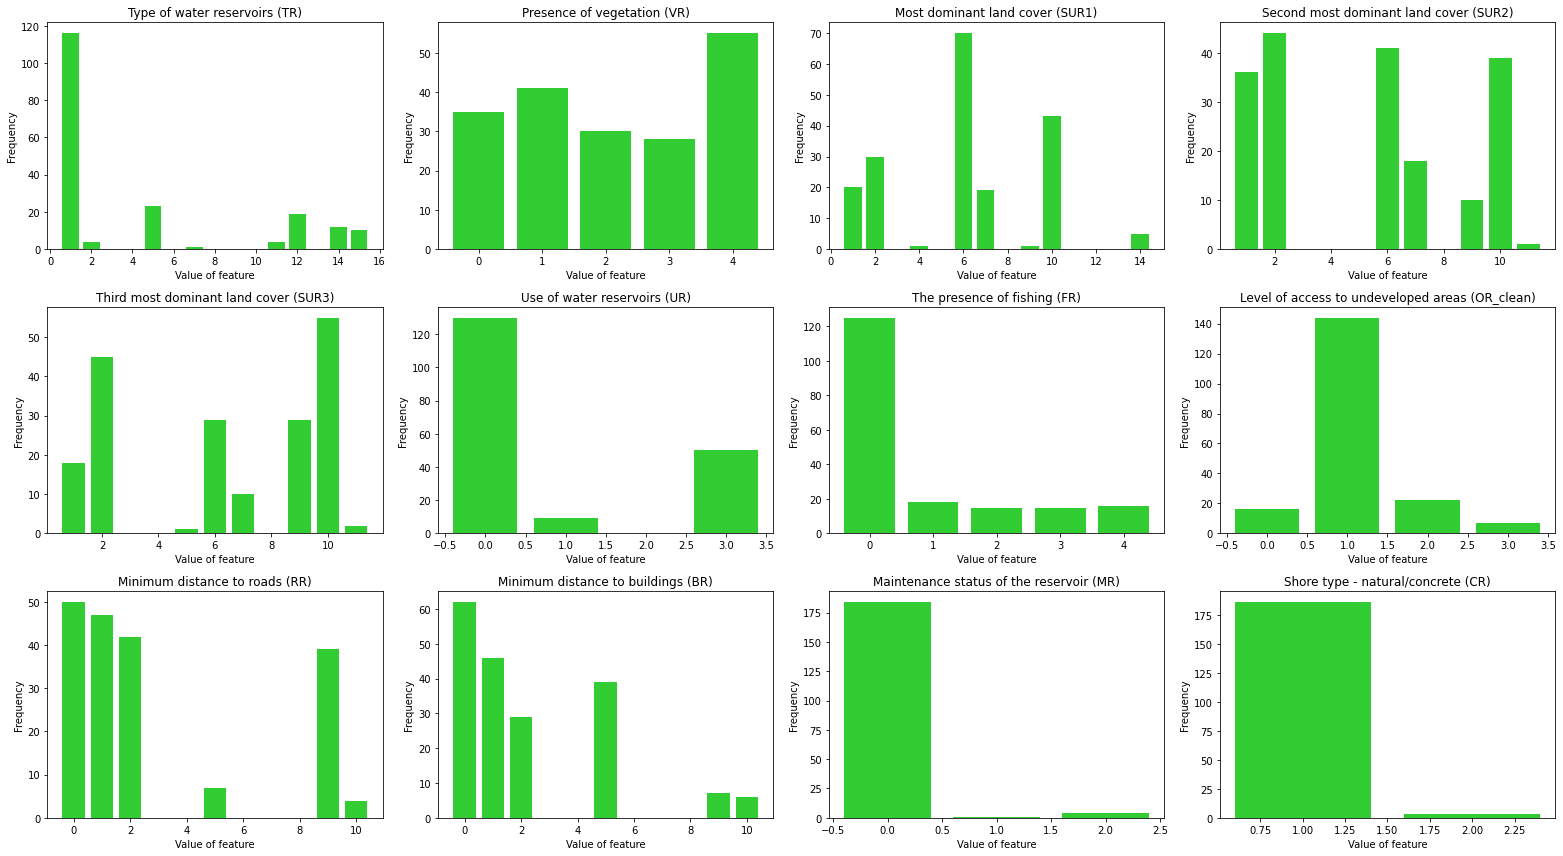

In [28]:
## look at the distribution of unique values across the categorical features             
fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize = (22,12))

## indices of axes/plots and common labels
i = 0
j = 0        
ylabel = "Frequency"
xlabel = "Value of feature"
for a in ax.flat:
    a.set(xlabel = xlabel, ylabel = ylabel)

## build the plots
ax[i,j].bar(TR_list, df.TR.value_counts(), color ='limegreen')
ax[i,j].set(title = "Type of water reservoirs (TR)")

## next column
j = j + 1
ax[i,j].bar(VR_list, df.VR.value_counts(), color ='limegreen')
ax[i,j].set(title = "Presence of vegetation (VR)")

## next column
j = j + 1
ax[i,j].bar(SUR1_list, df.SUR1.value_counts(), color ='limegreen')
ax[i,j].set(title = "Most dominant land cover (SUR1)")

## next column
j = j + 1
ax[i,j].bar(SUR2_list, df.SUR2.value_counts(), color ='limegreen')
ax[i,j].set(title = "Second most dominant land cover (SUR2)")

## next row, first column
i = i + 1
j = 0
ax[i,j].bar(SUR3_list, df.SUR3.value_counts(), color ='limegreen')
ax[i,j].set(title = "Third most dominant land cover (SUR3)")

## next column
j = j + 1
ax[i,j].bar(UR_list, df.UR.value_counts(), color ='limegreen')
ax[i,j].set(title = "Use of water reservoirs (UR)")

## next column
j = j + 1
ax[i,j].bar(FR_list, df.FR.value_counts(), color ='limegreen')
ax[i,j].set(title = "The presence of fishing (FR)")

## next column
j = j + 1
ax[i,j].bar(OR_clean_list, df.OR_clean.value_counts(), color ='limegreen')
ax[i,j].set(title = "Level of access to undeveloped areas (OR_clean)")

## next row, first column
i = i + 1
j = 0
ax[i,j].bar(RR_list, df.RR.value_counts(), color ='limegreen')
ax[i,j].set(title = "Minimum distance to roads (RR)")

## next column
j = j + 1
ax[i,j].bar(BR_list, df.BR.value_counts(), color ='limegreen')
ax[i,j].set(title = "Minimum distance to buildings (BR)")

## next column
j = j + 1   
ax[i,j].bar(MR_list, df.MR.value_counts(), color ='limegreen')
ax[i,j].set(title = "Maintenance status of the reservoir (MR)")

## next column
j = j + 1   
ax[i,j].bar(CR_list, df.CR.value_counts(), color ='limegreen')
ax[i,j].set(title = "Shore type - natural/concrete (CR)")

## show the plots
plt.tight_layout()
plt.show()

Looking at the categorical features displayed in this way, we can see that some will be more significant for the model than others.  For example, features MR, Maintenance status, and CR, Shore type, are so unbalanced that they are unlikely to contribute much information.  Still, they will be retained in the dataset to be consistent with the original paper.  Other features show more variation which will hopefully lead to reliable predictions.  

## Pre-processing and running the model

In considering which machine learning model to use for this binary classification problem, we note that Blachnik *et al* restricted their choice to the Decision tree (DT) family of models.  They considered that the preprocessing stage required by more complex models would obscure the results, and were aware that DT-based models had been used successfully by other researchers in this field.  As well as the standard Decision tree, they studied several similar models:  Random forest (RF), AdaBoost and Gradient-boosted trees (GBT).  For their multiclass problem, they found that GBT gave the best result overall, and used this model for their analysis.  However in the trial data they report for each model investigated, accuracy was higher for the RF model when looking at Green frogs alone.  Therefore an RF model is the choice for this analysis.

###Model-specific preprocessing


Having chosen the model, we should consider if we need to pre-process the data for best results.  Random forest classifiers can produce good results from many types of input data, but they have a tendency to over-rely on features that have a large range, or many values.  

Looking back to the data exploration we recall that feature SR, Surface area, had a range of several orders of magnitude, from 30m<sup>2</sup> to 500,000m<sup>2</sup>.  One way to reduce the range of a feature is to take logarithms of the values, so to see the effect of this, the original feature SR and the proposed new feature log<sub>10</sub> SR were plotted for comparison.


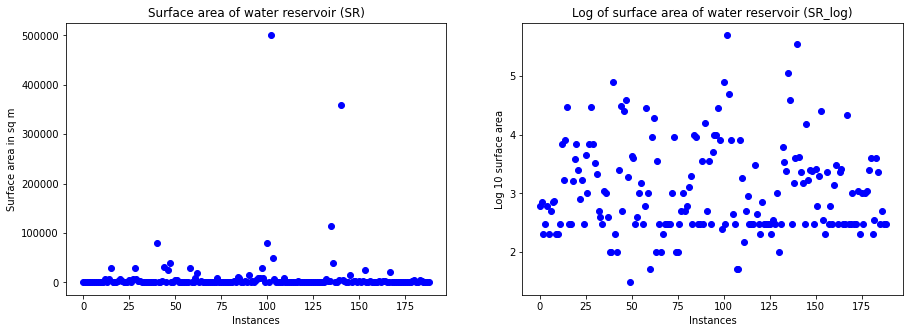

In [29]:
## visualise the different reservoir sizes
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

ax[0].set(xlabel = "Instances", ylabel = "Surface area in sq m")
ax[1].set(xlabel = "Instances", ylabel = "Log 10 surface area")

ax[0].scatter(instances, df.SR, color ='blue')
ax[0].set(title = "Surface area of water reservoir (SR)")

## take logs base 10 then plot again
df["SR_log"] = np.log10(df["SR"])
ax[1].scatter(instances, df.SR_log, color ='blue')
ax[1].set(title = "Log of surface area of water reservoir (SR_log)")

plt.show()

It is clear from the plots above that the scale of proposed feature SR_log is much reduced over that of original feature SR, but it still has many distinct values, which may be overly influential.  Therefore the logarithmic values will be rounded to the nearest integer, to become categorical values, as illustrated in the frequency distribution plot below.

In [30]:
## we will round the logarithms to the nearest integer 
df.SR_log = round(df.SR_log).astype(int)

## show individual values
SR_log_list = df['SR_log'].unique()
print("Values found in feature SR_log:", *SR_log_list)

Values found in feature SR_log: 3 2 4 5 1 6


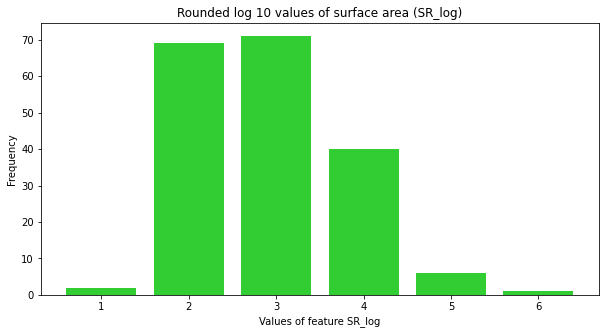

In [31]:
## plot the distribution of new feature SR_log
fig = plt.figure(figsize = (10,5))
plt.bar(SR_log_list, df.SR_log.value_counts(), color ='limegreen') 
plt.title("Rounded log 10 values of surface area (SR_log)")
plt.xlabel("Values of feature SR_log")
plt.ylabel("Frequency")
plt.show()

Creating a new feature for the surface area using rounded logarithms preserves the difference between instances while reducing the range of the feature considerably.  The new feature SR_log shows a limited but significant variation that should be useful in making predictions.

In [32]:
## drop the original feature SR now we have converted it
df = df.drop(["SR"], axis = 1)

To assist with the techniques that will be used later, the category fields are converted to numeric fields.

In [33]:
## category columns
cat_columns = df.select_dtypes(['category']).columns

## convert the category columns to integer
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   NR                  189 non-null    int64
 1   TR                  189 non-null    int8 
 2   VR                  189 non-null    int8 
 3   SUR1                189 non-null    int8 
 4   SUR2                189 non-null    int8 
 5   SUR3                189 non-null    int8 
 6   UR                  189 non-null    int8 
 7   FR                  189 non-null    int8 
 8   RR                  189 non-null    int8 
 9   BR                  189 non-null    int8 
 10  MR                  189 non-null    int8 
 11  CR                  189 non-null    int8 
 12  Green_frogs         189 non-null    int64
 13  Brown_frogs         189 non-null    int64
 14  Common_toad         189 non-null    int64
 15  Fire_bellied_toad   189 non-null    int64
 16  Tree_frog           189 non-null    int64
 1

### Running the model

Before we run the model and attempt to improve it by tuning of hyperparameters, it is necessary to decide on an appropriate measure (or measures) of accuracy.  Blachnik *et al* consider the unbalanced nature of the dataset, and choose Balanced Accuracy (BAcc) and Area under the ROC curve (AUC), so for comparison, those measures will be adopted here.  The model will be tuned with BAcc, and AUC examined for confirmation.

Next the labels for all classes are dropped from the dataframe, and the data (X) and labels (y) for the dataset will be assigned.

In [34]:
## now set up our X and y dataframes
X = df.drop(["Green_frogs", "Brown_frogs", "Common_toad", "Fire_bellied_toad", "Tree_frog", "Common_newt", "Great_crested_newt"], axis = 1)
y = df["Green_frogs"]

In [35]:
## get column names (now all feature cleansing/engineering is complete)
feat_names = X.columns.tolist()

Next the dataset is split into training and test data and the dimensions of each reported on.

In [36]:
## set up training and test datasets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42) 

print("X_train dimensions:", np.shape(X_train))
print("y_train dimensions:", np.shape(y_train))
print("X_test dimensions:", np.shape(X_test))
print("y_test dimensions:", np.shape(y_test))

X_train dimensions: (141, 14)
y_train dimensions: (141,)
X_test dimensions: (48, 14)
y_test dimensions: (48,)


The RF classifier model is initially applied to the training set with default parameters (except random state, to ensure reproducible results).  Predictions are made and BAcc calculated for both training and test datasets.  Comparing test and training accuracy is helpful in assessing the model and choosing the hyperparameters.  If training accuracy is higher than test accuracy by a significant amount, the model is overfitted and not generalising well.  If accuracies are similar across the two sets of data, that indicates good generalisation.  

In [37]:
## apply the model with default parameters
clf = RandomForestClassifier(random_state = 42)

## fit to data
clf.fit(X_train, y_train)

## compare training and test accuracy                     
train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Balanced accuracy on training data:", "{0:.3}".format(balanced_accuracy_score(y_train, train_pred)))
print("Balanced accuracy on test data:    ", "{0:.3}".format(balanced_accuracy_score(y_test, y_pred)))

Balanced accuracy on training data: 1.0
Balanced accuracy on test data:     0.614


Using default settings to build our random forest, we can see we have perfect accuracy on our training data (overfitting), and a BAcc of 0.61 on the test data. It was also noted that the decision trees created with the default hyperparameters were deep, some examples being 15 nodes deep (compare this with the fact that our dataset only has 14 features). 

We can compare this value for BAcc with the accuracy of a simple model that always predicted the majority class.

In [38]:
## Calculate accuracy  
print("A simple model choosing the majority class would have a balanced accuracy of:", "{0:.3}".format(108 / 189))

A simple model choosing the majority class would have a balanced accuracy of: 0.571


Our initial model does better than the simple model, but not by much.  Therefore we need to consider how we might improve it, by tuning the hyperparameters of the model.  

The model was trained while adjusting the following parameters individually (all other parameters were set to default values, unless stated) and manually:

* n_estimators, the number of trees in the forest (default 100)
* criterion, measure of quality of a split (default = gini)
* max_depth, limit to depth of tree (default = None)
* min_samples_split, minimum no of samples for a node to be split (default = 2)
* min_samples_leaf, minimum no of samples in a leaf node (default = 1)
* max_leaf_nodes, limit to no of leaves (default = None)
* min_impurity_decrease, required minimum for a node to be split (default = 0.0)
* max_samples, maximum samples in each tree (default = None)

Changes to n_estimators, criterion, and min_samples_split only decreased the balanced accuracy of the model.  Changes to min_impurity_decrease made BAcc much lower, indicting that the information gain on each split must be small.

Changes in accuracy seen when altering max_depth, min_samples_leaf, max_leaf_nodes and max_samples were varied, with some increasing and some decreasing BAcc.  Therefore these parameters were varied in combination in further (again manual) testing, to arrive at an improved set of parameters.

In [39]:
## apply the model with optimised parameters 
clf = RandomForestClassifier(max_depth = 3, 
                             min_samples_leaf = 4, 
                             max_leaf_nodes = 4, 
                             max_samples = 25,
                             random_state = 42)
## fit to training data
clf_fitted = clf.fit(X_train, y_train)

## compare training and test accuracy                     
train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Balanced accuracy on training data:", "{0:.3}".format(balanced_accuracy_score(y_train, train_pred)))
print("Balanced accuracy on test data:    ", "{0:.3}".format(balanced_accuracy_score(y_test, y_pred)))

Balanced accuracy on training data: 0.745
Balanced accuracy on test data:     0.704


By keeping the number of samples used in each tree to a fairly small number (approximately 13% of the dataset), and preventing leaves from being created for small numbers of instances, the unwieldy growth of the individual trees has been curtailed.

This tuning reduces the training accuracy from 1.00 to 0.75, as we might expect; however the balanced accuracy on the test dataset has increased from 0.61 to 0.70.
We note this is higher than both the Balanced accuracies reported in Blachnik *et al* for Green frogs.  For their RF model they report 67.44% Balanced accuracy, and for the Gradient-boosted trees (GBT) model (which is the model chosen due to its greater accuracy for other amphibian species) the value is 66.51%.  The models are likely to differ since we are running a binary classification task compared to their multiclass classification, but it is encouraging to have these results.

To complete our study of the model, a few of the individual trees (or estimators) from the RF were plotted for inspection, as well as the confusion matrix and ROC-AUC plot.

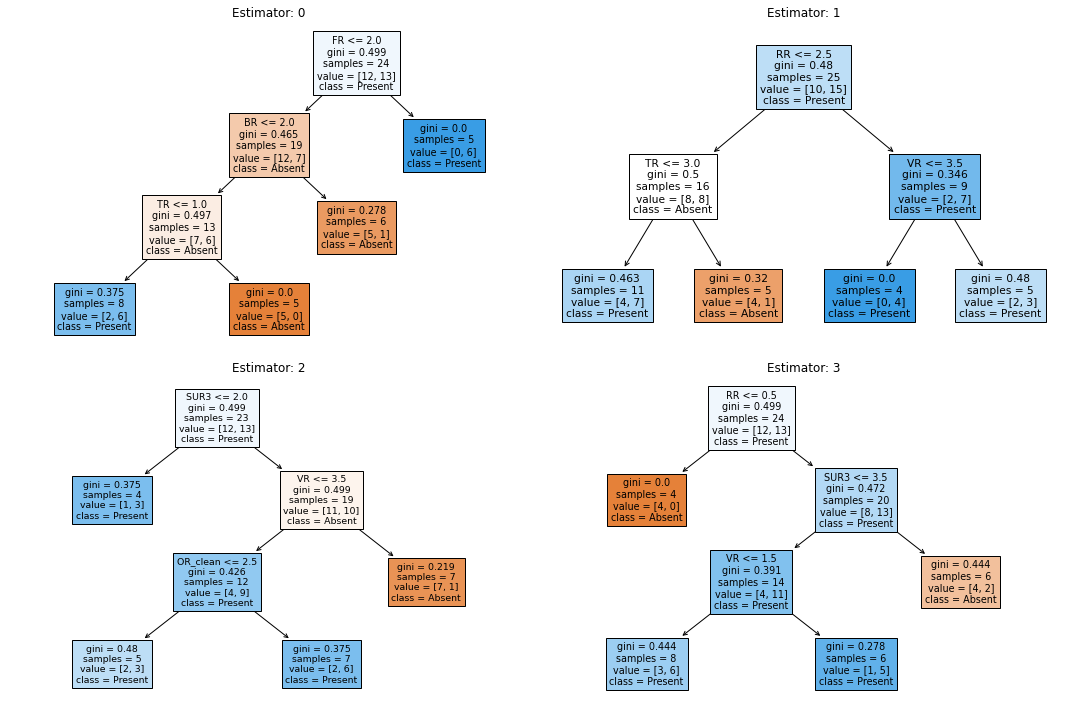

In [40]:
## looking at some of the trees generated...
fig, ax = plt.subplots(nrows = 2,ncols = 2,figsize = (15,10))

## show the first 4 estimators in the forest
for i in range(0,2):
  for j in range(0,2):
    tree.plot_tree(clf.estimators_[(i * 2) + j],
                 feature_names = feat_names, 
                 class_names=class_labels,
                 filled = True,
                 ax = ax[i,j]);                  
    ## titles
    ax[i,j].set_title('Estimator: ' + str((i * 2) + j) )

## format spacing
plt.tight_layout()

##### why do values add to more than samples? 
## see https://stackoverflow.com/questions/54134359/how-to-interpret-unexpected-values-of-sklearn-tree-tree-tree-value-attribute

These example trees show that some splits are better than others, for example Estimator 3 creates an 'Absent' class leaf with no incorrect instances (4,0), but the other 'Absent' leaf in this tree has a split of (4,3), which is of little value.

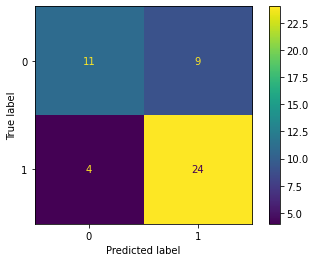

In [41]:
## create confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

The confusion matrix shows us that the model is much better at predicting true positives (24 out of 28 correct) than true negatives (only 11 out of 20 correct).  This may be due to the unbalanced nature of the dataset, and its small size.

ROC AUC: 0.704
FPR: [0.   0.45 1.  ]
TPR: [0.         0.85714286 1.        ]
Thresholds: [2 1 0]


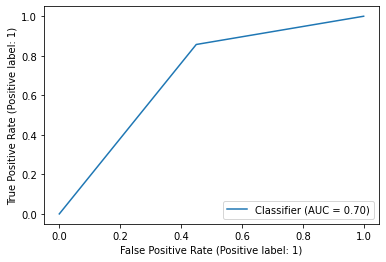

In [42]:
## now look at ROC and AUC
fpr, tpr, thresh = roc_curve(y_test, y_pred, pos_label = 1)

## calculate area under the curve
roc_auc = metrics.auc(fpr, tpr)
RocCurveDisplay.from_predictions(y_test, y_pred, pos_label = 1)

print("ROC AUC:", "{0:.3}".format(roc_auc))
print("FPR:", fpr)
print("TPR:", tpr)
print("Thresholds:", thresh)

Similarly to BAcc, the Area under the curve (AUC) value is 0.70.  This should be seen in the context that a model with AUC = 0.5 tells us nothing, while a model with AUC = 1 is perfect.

## Explaining the results (XAI)

To this point we have judged the model on Balanced accuracy and AUC, which give single numbers.  To be able to decide whether this model is appropriate and effective for the task in hand, we need to explore and explain it in more detail.  The first step is to determine which features of the dataset have been most influential in the model.  Following this two explainability (XAI) techniques will be run.

The first XAI technique analyses the global model, to study how it makes decisions in general.  Subsequently a local XAI technique will be used to investigate the model's behaviour on a selection of data instances.

### Feature importance

We can use the SHAP method to show the relative importance of the different features in terms of their effect on the prediction.  SHAP (Shapley additive explanations) is a model-agnostic technique based on game theory, which can produce a variety of plots to show different aspects of the model.  Here we will only look at feature importance.

In [43]:
## create shap explainer for our model
shap_explainer = shap.TreeExplainer(clf_fitted)

## calculate shap values
shap_values = shap_explainer.shap_values(X_test)

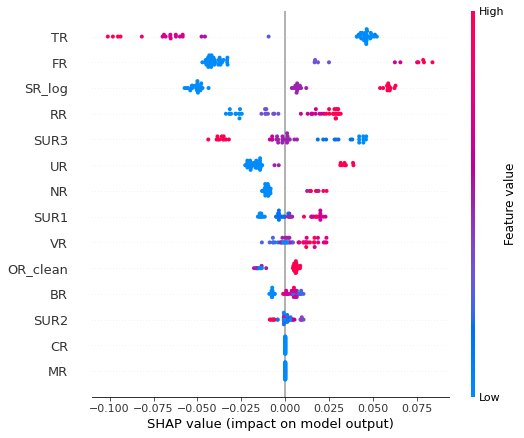

In [44]:
## feature importance plots...
shap.summary_plot(shap_values[1], X_test)

From the SHAP plot above we can see why feature TR is so significant in making predictions, as it shows a clear separation between values that have a negative effect on the prediction and those that have a positive effect.

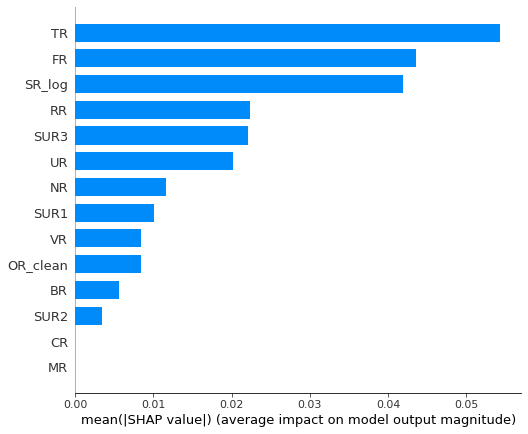

In [45]:
## and
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

In both the SHAP summary plots we can see the relative importance of the different features to the predictions of the model.  It is interesting to compare these with the values given by Blachnik *et al* who calculated (normalised) feature importance for Green frogs individually as set out here, using their GBT model.

>TR - 1.00  
>SR - 0.90  
>SUR2 - 0.61  
>SUR3 - 0.61  
>SUR1 - 0.52  
>FR - 0.39  
>VR - 0.31  
>RR - 0.29  
>UR - 0.11  
>BR - 0.11  
>NR - 0.00   
>MR - 0.00  
>CR - 0.00  

It is interesting to note that the models choose the same two features, TR, SR(_log) as the most important.  After that there is more variation between them, although features FR and SUR3 are in the top six for both models.  After that the RF model favours features RR and UR, while the GBT chooses SUR1 and SUR2 as more relevant.  Some variation is to be expected due to different steps taken in each case, but it is reassuring that the similarities are strong.

Both models assign a feature importance of zero to features MR and CR, as was expected from their frequency distributions plotted above.



In [46]:
## specify the 6 most important features TR, SR_log, FR, RR, SUR3, UR
feat_imp = [1, 13, 7, 8, 5, 6]
print("Most important features found by RF model")

for i in range(0, len(feat_imp)):
  print(feat_names[feat_imp[i]])

Most important features found by RF model
TR
SR_log
FR
RR
SUR3
UR


###Global explainability

To better understand the model globally, we will use the model-agnostic Partial dependence plots (PDP) and Individual conditional expectations (ICE) techniques on the features that have been found to be important.  These related methods can show us how the prediction varies based on individual features.  

Note that both PDP and ICE assume feature independence, but Blachnik *et al* report some correlation amongst features, most significantly between the pairs BR,RR (distance to buildings, distance to roads) and FR,UR (Fishing and Use).  Feature dependence means that in perturbing the data we will be creating unrealistic data instances.

Unfortunately three of these features appear in the six most significant features, as detected by SHAP, so we should be wary in drawing conclusions in these cases.

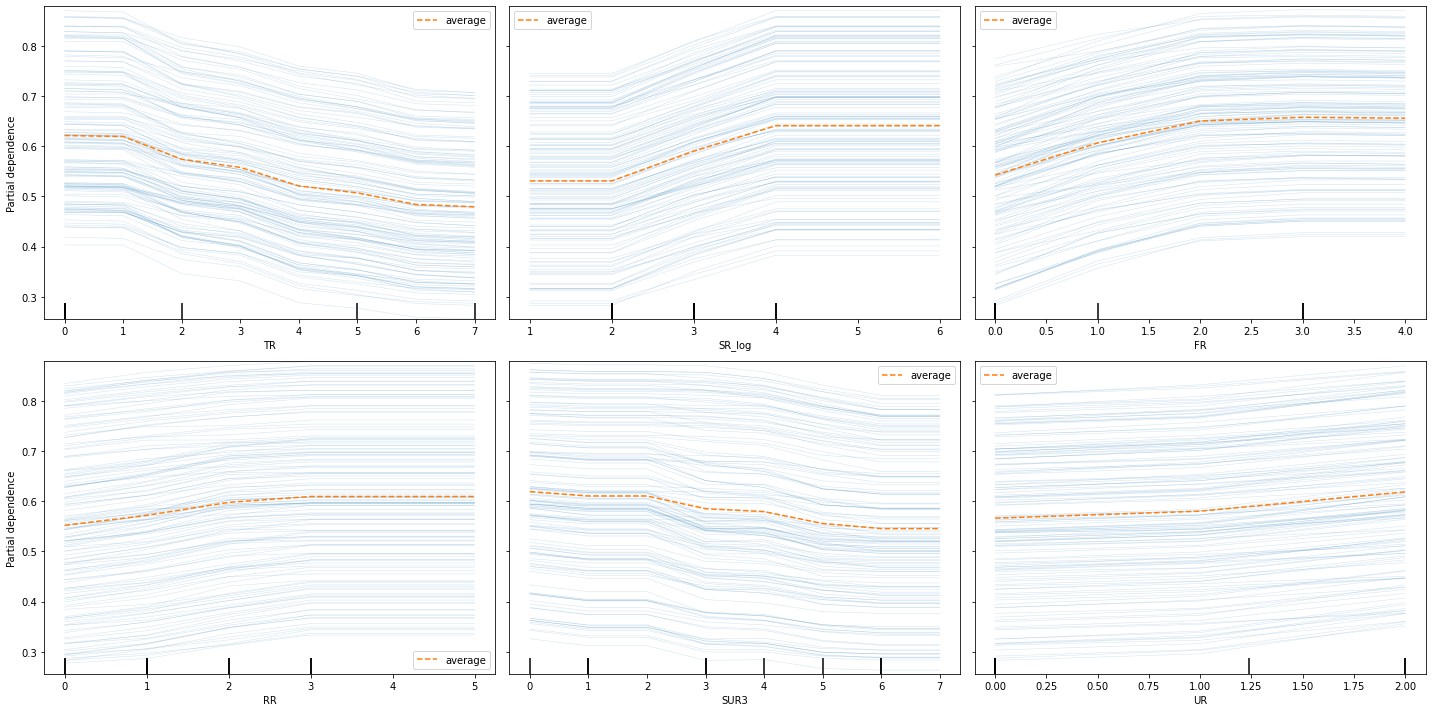

In [47]:
## partial dependence plots
fig, ax = plt.subplots(nrows = 2, ncols = 3,figsize = (20, 10))   

disp = PartialDependenceDisplay.from_estimator(clf, 
                                               X_train,         
                                               feat_imp, 
                                               ax = ax,          
                                               ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
                                               pd_line_kw={"color": "tab:orange", "linestyle": "--"},
                                               kind='both')    
plt.tight_layout()

The plots above show the average partial dependence (orange dotted line) and individual conditional expectations (pale blue lines) for the six most important features.  Features that have the most effect on the predictions of the model are those where the partial dependence shown on the plots above has the greatest range.  Here the feature TR is clearly the most significant.

The ICE plot can often yield detail that an average hides, but for this model the feature value changes are very uniform, indicating that there are effectively no heterogeneous effects among the instances.

### Local explainability

We now attempt to examine the model in a different way, by inspecting individual predictions for plausibility.  This will be done using the Local interpretable model-agnostic explanations technique (LIME), which produces visualisations for individual instances, showing which features contributed to, and which detracted from, the prediction.

In [48]:
## create a Lime explainer 
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode = "classification",
                                                   feature_names = feat_names,
                                                   class_names = class_labels)   

In [49]:
## Warning suppressed:
### /usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
###  "X does not have valid feature names, but"

Having built the Lime explainer, we can use it to study the predictions made for different data instances.  It will be informative to pick examples where the model is confident, and where it is not, to compare how the feature values lead to those predictions.

In [50]:
## find the probabilities 
probs = clf.predict_proba(X_test)

## define lists for the 2 groups of indices: lower = uncertain, upper = confident
lower = []
upper = []

## for all the probabilities of class 1
for i in range(0, probs.shape[0]):              
  ## uncertain ones chosen from either side of boundary
  if (0.49 <= probs[i][1] <= 0.515):           
    lower.append(i)
  if (0.73 <= probs[i][1]):
    upper.append(i)

## review the results
print("No. of rows", probs.shape[0])
print("Uncertain indices,", len(lower), "found:", lower)
print("Confident indices,", len(upper), "found:", upper)

No. of rows 48
Uncertain indices, 4 found: [8, 10, 28, 47]
Confident indices, 4 found: [14, 23, 32, 40]


Two random instances were selected from each of the lists just generated, to study their predictions using the Lime explainer.

In [51]:
## create sets of uncertain and confident instances for the model    
uncertain = set(lower)
confident = set(upper)

## choose two random instances from each
unc = random.sample(tuple(uncertain), k = 2)
con = random.sample(tuple(confident), k = 2)

## report on instances chosen
print("Uncertain instances chosen are", unc, "with probabilities for class 1:", "{0:.3}".format(probs[unc][0][1]), "and", "{0:.3}".format(probs[unc][1][1]))
print("Confident instances chosen are", con, "with probabilities for class 1:", "{0:.3}".format(probs[con][0][1]), "and", "{0:.3}".format(probs[con][1][1]))

Uncertain instances chosen are [8, 47] with probabilities for class 1: 0.495 and 0.512
Confident instances chosen are [14, 32] with probabilities for class 1: 0.731 and 0.761


First the explanations of the uncertain instances will be generated, again choosing the six most important features.

In [52]:
## examine the uncertain instances
num_feat = 6            

for i in range(0,2):
  print("\nUncertain instance", unc[i], "has data values", X_test.values[unc][i], "and prediction", y_pred[unc[i]], "\n")

  ## explain the instances
  exp = lime_explainer.explain_instance(X_test.values[unc][i], clf.predict_proba, num_features = num_feat)
  ## display results
  exp.show_in_notebook(show_table = True)

Output hidden; open in https://colab.research.google.com to view.

The uncertain instances have different predictions: instance 8 predicts absence of Green frogs (0) and instance 28 predicts presence (1).  However the Lime explainer has chosen the same set of features as the six most important.  The model is uncertain of these predictions because some feature values make the presence of frogs more likely (shown in orange), and others make it less likely (shown in blue), leaving the decision finely balanced.  Looking at the feature values on the right, we can see these data instances are very similar.

Next the two instances where the model was confident are explained.

In [53]:
## examine the confident instances
for i in range(0,2):
  print("\nConfident instance", con[i], "has data values", X_test.values[con][i], "and prediction", y_pred[con[i]], "\n")

  ## explain the instances
  exp = lime_explainer.explain_instance(X_test.values[con][i], clf.predict_proba, num_features = num_feat)
  ## display results
  exp.show_in_notebook(show_table = True)

Output hidden; open in https://colab.research.google.com to view.

We can see that the predictions the model has a lot of confidence in are those where multiple features are indicating the presence of frogs.  There are more differences in the actual feature value between instances 23 and 32, but the confidences in the predictions are similar (0.74 and 0.76).  There are still features indicating absence for each instance (RR in particular), but the effect is outweighed by the other feature values.

A domain expert would be able to make an informed judgement on the accuracy of this model, based on the explanations above.

## Conclusion

For this investigation we posited an ecologist wishing to test the conclusions of a road-building study.  Using the same dataset, and a similar model, predictions were made, accuracy examined, feature importance determined, and two contrasting XAI techniques were applied to the results.  By combining XAI techniques we can ensure we have examined the model thoroughly and can have confidence in its reasoning.  The model proved to have a comparable accuracy to that of Blachnik *et al*, and produced feasible results.

The ecologist we proposed as the author of this study understands that this is a simplistic model, but is satisfied that it seems to confirm the findings of Blachnik *et al*.  They will also take forward what has been learned from the feature importance analysis in their future work on amphibian ecosystems.

### Further development

Ways this dataset could be investigated further include:

* Clarify the mapping from feature values to feature descriptions; 
* Use under- or over-sampling to make the dataset more balanced;
* Train the model as a multi-class classifier (as done by Blacknik *et al*);
* Expand the dataset using the same data-collection methodology, so the model has access to more instances for training;
* Automate tuning of hyperparameters, to ensure the best combination have been found;
* Train the model (still as a binary classifier) to include the labels for other amphibians as features, to see if their presence at a location is relevant to the prediction of Green frogs' presence.  For example, Common newts eat tadpoles [https://www.wwt.org.uk/discover-wetlands/wetland-wildlife/amphibians/].

